In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from datetime import datetime
from scipy import stats

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from mlxtend.feature_selection import ColumnSelector
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

### 用户-商家特征提取

+ 用户领取商家的优惠券次数
+ 用户领取商家的优惠券后核销次数
+ 用户领取商家的优惠券后核销率
+ 用户对每个商家的不核销次数占用户总的不核销次数的比重
+ 用户对每个商家的优惠券核销次数占用户总的核销次数的比重
+ 用户对每个商家的不核销次数占商家总的不核销次数的比重
+ 用户对每个商家的优惠券核销次数占商家总的核销次数的比重

In [4]:
base_features_df = pd.read_csv('../features/lcm_base_features.csv')
user_features_df = pd.read_csv('../features/lcm_user_features.csv')
merchant_features_df = pd.read_csv('../features/lcm_merchant_features.csv')

In [5]:
base_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053282 entries, 0 to 1053281
Data columns (total 14 columns):
User_id              1053282 non-null int64
Merchant_id          1053282 non-null float64
Coupon_id            1053282 non-null float64
Distance             1053282 non-null float64
Date_received        1053282 non-null float64
Is_in_day_consume    1053282 non-null float64
Discount             1053282 non-null float64
Base_consume         1053282 non-null float64
Discount_money       1053282 non-null float64
Day_in_month         1053282 non-null float64
Day_in_week          1053282 non-null float64
Coupon_type          1053282 non-null float64
Offline_consume      1053282 non-null float64
Duration             1053282 non-null float64
dtypes: float64(13), int64(1)
memory usage: 112.5 MB


In [6]:
def is_debug_df(df, date=20160501, debug=True):
    if debug:
        return df[df['Date_received']<date]
    else:
        return df.copy()
    
df = is_debug_df(base_features_df)

In [7]:
def join(df, col, series, key):
    return multi_join(df, col, series, [key])

def multi_join(df, col, series, keys):
    t = series.to_frame()
    t.columns = [col]
    
    return pd.merge(df, t, on=keys, how='left')

In [8]:
def receive_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Date_received']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Date_received']>0][target].groupby(groupby).size()

def cousume_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Offline_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Offline_consume']>0][target].groupby(groupby).size()

def used_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Is_in_day_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Is_in_day_consume']>0][target].groupby(groupby).size()

def cal_user_used_coupon_rate(row):
    return row.User_used_count/row.User_receive_count

def cal_user_not_used_conpon_count(row):
    return row.User_receive_count - row.User_used_count

def extract_info(df, target, type, groupby, column_name, is_dup=True):
    factory = {
        'receive_type': receive_count,
        'used_type': used_count
    }
    
    target_df = df[groupby].drop_duplicates()
    series = factory[type](df, target, groupby, is_dup)
    
    tdf = multi_join(target_df, column_name, series, groupby)
    tdf = tdf.fillna(0)
    
    mean = tdf[column_name].mean()
    tdf[column_name+'_occ'] = tdf[column_name] / mean
    return tdf[groupby + [column_name, column_name+'_occ']]

In [9]:
class GroupbyExtractor(TransformerMixin):
    def __init__(self, fn, target, type, groupby, column_name):
        self.fn = fn
        self.target = target
        self.type = type
        self.groupby = groupby
        self.column_name = column_name
    
    def fit(self, *args, **kwargs):
        return self

    def transform(self, X, **transform_params):
        return self.fn(X, self.target, self.type, self.groupby, self.column_name)

In [10]:
keys = ['User_id','Merchant_id']
user_merchant_features_df = df[keys].drop_duplicates()
user_merchant_features_df = pd.merge(user_merchant_features_df, user_features_df, on=['User_id'], how='left')
user_merchant_features_df = pd.merge(user_merchant_features_df, merchant_features_df, on=['Merchant_id'], how='left')

user_merchant_features_df = pd.merge(user_merchant_features_df, extract_info(df, keys, 'receive_type', keys, 'User_merchant_receive_count', False), on=keys, how='left')
user_merchant_features_df = pd.merge(user_merchant_features_df, extract_info(df, keys, 'used_type', keys, 'User_merchant_used_count', False), on=keys, how='left')

user_merchant_features_df = pd.merge(user_merchant_features_df, extract_info(df, ['User_id', 'Merchant_id', 'Coupon_id'], 'receive_type', keys, 'User_merchant_receive_diff_coupon_count'), on=keys, how='left')
user_merchant_features_df = pd.merge(user_merchant_features_df, extract_info(df, ['User_id', 'Merchant_id', 'Coupon_id'], 'used_type', keys, 'User_merchant_used_diff_coupon_count'), on=keys, how='left')

for i in range(0, 2, 1):
    
    user_merchant_features_df = pd.merge(
        user_merchant_features_df, 
        extract_info(
            df[df['Coupon_type'] == i], 
            ['User_id', 'Merchant_id', 'Coupon_type'], 
            'receive_type', keys, 
            'User_merchant_receive_coupon_type_%s_count' % (i),
            False
        ), 
        on=keys, how='left'
    )
    
    user_merchant_features_df = pd.merge(
        user_merchant_features_df, 
        extract_info(
            df[df['Coupon_type'] == i], 
            ['User_id', 'Merchant_id', 'Coupon_type'], 
            'used_type', 
            keys, 
            'User_merchant_used_coupon_type_%s_count' % (i),
            False
        ), on=keys, how='left')
    
    user_merchant_features_df['User_merchant_used_coupon_type_%s_rate' % (i)] = user_merchant_features_df['User_merchant_used_coupon_type_%s_count' % (i)] / user_merchant_features_df['User_used_count']
    user_merchant_features_df['User_merchant_used_coupon_type_%s_personal_rate' % (i)] = user_merchant_features_df['User_merchant_used_coupon_type_%s_count' % (i)] / user_merchant_features_df['User_merchant_used_count']

user_merchant_features_df['User_merchant_used_personal_rate'] = user_merchant_features_df['User_merchant_used_count'] / user_merchant_features_df['User_merchant_receive_count']
user_merchant_features_df['User_merchant_used_rate'] = user_merchant_features_df['User_merchant_used_count'] / user_merchant_features_df['User_used_count']

user_merchant_features_df['User_merchant_receive_diff_coupon_rate'] = user_merchant_features_df['User_merchant_receive_diff_coupon_count'] / user_merchant_features_df['Merchant_receive_different_coupon_count']
user_merchant_features_df['User_merchant_used_diff_coupon_rate'] = user_merchant_features_df['User_merchant_used_diff_coupon_count'] / user_merchant_features_df['Merchant_used_different_coupon_count']

user_merchant_features_df = user_merchant_features_df.fillna(0)
user_merchant_features_df['User_merchant_used_rate_occ'] = user_merchant_features_df['User_merchant_used_rate'] / user_merchant_features_df['User_merchant_used_rate'].mean()
user_merchant_features_df['User_merchant_used_personal_rate_occ'] = user_merchant_features_df['User_merchant_used_personal_rate'] / user_merchant_features_df['User_merchant_used_personal_rate'].mean()
user_merchant_features_df['User_merchant_receive_diff_coupon_rate_occ'] = user_merchant_features_df['User_merchant_receive_diff_coupon_rate'] / user_merchant_features_df['User_merchant_receive_diff_coupon_rate'].mean()
user_merchant_features_df['User_merchant_used_diff_coupon_rate_occ'] = user_merchant_features_df['User_merchant_used_diff_coupon_rate'] / user_merchant_features_df['User_merchant_used_diff_coupon_rate'].mean()

In [11]:
t = base_features_df[['User_id', 'Merchant_id', 'Discount']].groupby(keys).agg(['mean', 'max', 'min'])
t.columns = ["_User_Merchant_".join(x) for x in t.columns.ravel()]
user_merchant_features_df = pd.merge(user_merchant_features_df, t, on=keys, how='left')

In [12]:
user_columns = user_features_df.columns.values
user_columns = user_columns[np.where(user_columns !='User_id')] 

user_merchant_features_df = user_merchant_features_df.drop(user_columns, axis=1)

merchant_columns = merchant_features_df.columns.values
merchant_columns = merchant_columns[np.where(merchant_columns !='Merchant_id')] 

user_merchant_features_df = user_merchant_features_df.drop(merchant_columns, axis=1)

In [13]:
user_merchant_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633751 entries, 0 to 633750
Data columns (total 33 columns):
User_id                                           633751 non-null int64
Merchant_id                                       633751 non-null float64
User_merchant_receive_count                       633751 non-null int64
User_merchant_receive_count_occ                   633751 non-null float64
User_merchant_used_count                          633751 non-null float64
User_merchant_used_count_occ                      633751 non-null float64
User_merchant_receive_diff_coupon_count           633751 non-null int64
User_merchant_receive_diff_coupon_count_occ       633751 non-null float64
User_merchant_used_diff_coupon_count              633751 non-null float64
User_merchant_used_diff_coupon_count_occ          633751 non-null float64
User_merchant_receive_coupon_type_0_count         633751 non-null float64
User_merchant_receive_coupon_type_0_count_occ     633751 non-null float64
User_me

In [14]:
user_merchant_features_df.columns.values

array(['User_id', 'Merchant_id', 'User_merchant_receive_count',
       'User_merchant_receive_count_occ', 'User_merchant_used_count',
       'User_merchant_used_count_occ',
       'User_merchant_receive_diff_coupon_count',
       'User_merchant_receive_diff_coupon_count_occ',
       'User_merchant_used_diff_coupon_count',
       'User_merchant_used_diff_coupon_count_occ',
       'User_merchant_receive_coupon_type_0_count',
       'User_merchant_receive_coupon_type_0_count_occ',
       'User_merchant_used_coupon_type_0_count',
       'User_merchant_used_coupon_type_0_count_occ',
       'User_merchant_used_coupon_type_0_rate',
       'User_merchant_used_coupon_type_0_personal_rate',
       'User_merchant_receive_coupon_type_1_count',
       'User_merchant_receive_coupon_type_1_count_occ',
       'User_merchant_used_coupon_type_1_count',
       'User_merchant_used_coupon_type_1_count_occ',
       'User_merchant_used_coupon_type_1_rate',
       'User_merchant_used_coupon_type_1_personal_ra

In [15]:
user_merchant_features_df.head(20)

,User_id,Merchant_id,User_merchant_receive_count,User_merchant_receive_count_occ,User_merchant_used_count,User_merchant_used_count_occ,User_merchant_receive_diff_coupon_count,User_merchant_receive_diff_coupon_count_occ,User_merchant_used_diff_coupon_count,User_merchant_used_diff_coupon_count_occ,...,User_merchant_used_rate,User_merchant_receive_diff_coupon_rate,User_merchant_used_diff_coupon_rate,User_merchant_used_rate_occ,User_merchant_used_personal_rate_occ,User_merchant_receive_diff_coupon_rate_occ,User_merchant_used_diff_coupon_rate_occ,Discount_User_Merchant_mean,Discount_User_Merchant_max,Discount_User_Merchant_min
0,1439408,2632.0,2,1.69686,0.0,0.000000,2,1.861767,0.0,0.000000,...,0.0,1.000000,0.0,0.000000,0.000000,2.754092,0.000000,0.950000,0.950000,0.950000
1,1832624,3381.0,1,0.84843,0.0,0.000000,1,0.930883,0.0,0.000000,...,0.0,0.125000,0.0,0.000000,0.000000,0.344261,0.000000,0.900000,0.900000,0.900000
2,2029232,3381.0,1,0.84843,0.0,0.000000,1,0.930883,0.0,0.000000,...,0.0,0.125000,0.0,0.000000,0.000000,0.344261,0.000000,0.900000,0.900000,0.900000
3,2223968,3381.0,1,0.84843,0.0,0.000000,1,0.930883,0.0,0.000000,...,0.0,0.125000,0.0,0.000000,0.000000,0.344261,0.000000,0.500000,0.500000,0.500000
4,73611,2099.0,1,0.84843,0.0,0.000000,1,0.930883,0.0,0.000000,...,0.0,1.000000,0.0,0.000000,0.000000,2.754092,0.000000,0.900000,0.900000,0.900000
5,163606,1569.0,1,0.84843,0.0,0.000000,1,0.930883,0.0,0.000000,...,0.0,0.142857,0.0,0.000000,0.000000,0.393442,0.000000,0.850000,0.850000,0.850000
6,3273056,4833.0,1,0.84843,0.0,0.000000,1,0.930883,0.0,0.000000,...,0.0,0.500000,0.0,0.000000,0.000000,1.377046,0.000000,0.900000,0.900000,0.900000
7,94107,3381.0,1,0.84843,0.0,0.000000,1,0.930883,0.0,0.000000,...,0.0,0.125000,0.0,0.000000,0.000000,0.344261,0.000000,0.900000,0.900000,0.900000
8,253750,8390.0,1,0.84843,0.0,0.000000,1,0.930883,0.0,0.000000,...,0.0,1.000000,0.0,0.000000,0.000000,2.754092,0.000000,0.750000,0.750000,0.750000
9,376492,1041.0,1,0.84843,0.0,0.000000,1,0.930883,0.0,0.000000,...,0.0,0.250000,0.0,0.000000,0.000000,0.688523,0.000000,0.833333,0.833333,0.833333


In [16]:
user_merchant_features_df.to_csv('../features/lcm_user_merchant_features.csv', index=False, header=True)

## 数据分析

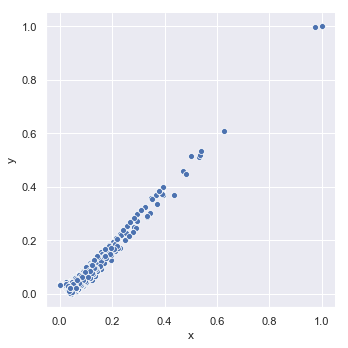

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

tdf = pd.read_csv('../features/lcm_user_merchant_features.csv')
tdf = tdf.drop(['User_id', 'Merchant_id'], axis=1)

ipipe = Pipeline([
    ('pca', PCA(n_components=2)),
    ('scale', MinMaxScaler()),
])

ipipe.fit(tdf)
output = ipipe.transform(tdf)
output_df = pd.DataFrame(data=output, columns=['x', 'y'])

sns.relplot(x="x", y="y", data=output_df);